This notebook walks through with limited explanation how noise gating works, and it is mainly a utility to generate the movie found in this folder. 

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import glob
import scipy.ndimage
import time

# Set global settings

Below the setting for the noise gating procedure are set. This implementation only uses the gating filter and not the Wiener filter mentin in Craig DeForest's paper. 

In [2]:
fft = np.fft.fftn
ifft = np.fft.ifftn
xwidth, ywidth, twidth = 12, 12, 12 # the size of the window in the two spatial and one temporal domains respectively
gamma = 3 # the scaling of the noise threshold. 

In [5]:
(xwidth // 2) - 1, (xwidth // 2) + 2

(5, 8)

# Load Data

Load all of the images into one cube.

In [5]:
path = "/Volumes/dijkstra/herschel_move/data/proc_fits/171/*.fits"
fns = glob.glob(path)
data = np.zeros((1280, 1280, len(fns))) # this is set for SUVI imagery which is 1280x1280
for i, fn in enumerate(fns):
    image_file = fits.open(fn)
    img = image_file[0].data.copy()
    
    # make sure all the entries are valid
    img[np.isnan(img)] = 0
    img[np.isinf(img)] = 0
    img[img < 0] = 0
    data[:,:,i] = img
    
    # uncomment below to add even more noise!
    data[:,:,i] = (img + 0.5*np.random.poisson(img)) # this adds shot noise of half the strength of the real signal
    image_file.close()

# Take a look at the image

<IPython.core.display.Javascript object>


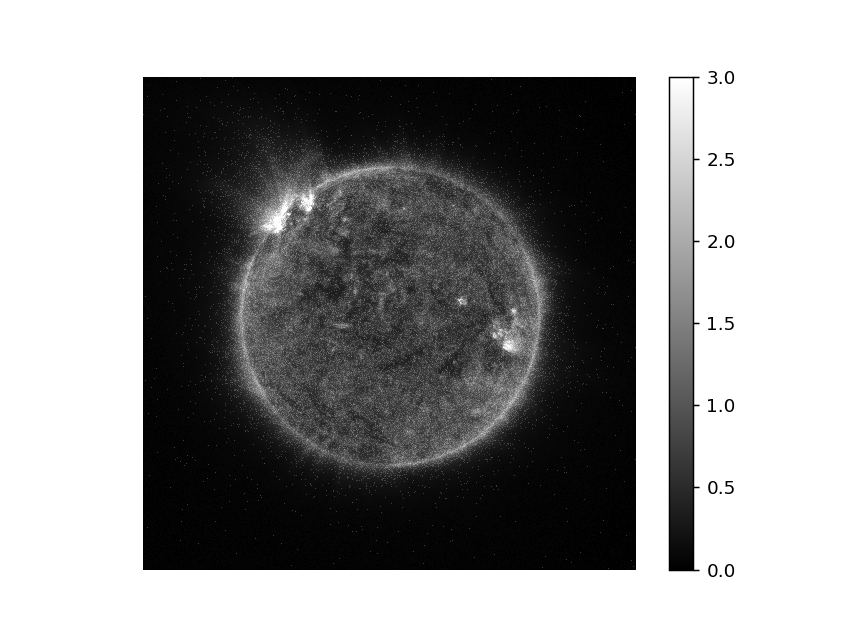

In [92]:
plt.figure()#figsize=(15,15))
plt.imshow(np.sqrt(data[:,:,5]), origin='lower', interpolation='None', vmax=3, cmap="gray")
plt.colorbar()
plt.axis("off")
plt.show()

Notice the salt and pepper type noise, shot noise, when you zoom in. It's dependent on the actual signal in a poisson distribution. Thus, it's more difficult to remove than simple approaches.

<IPython.core.display.Javascript object>


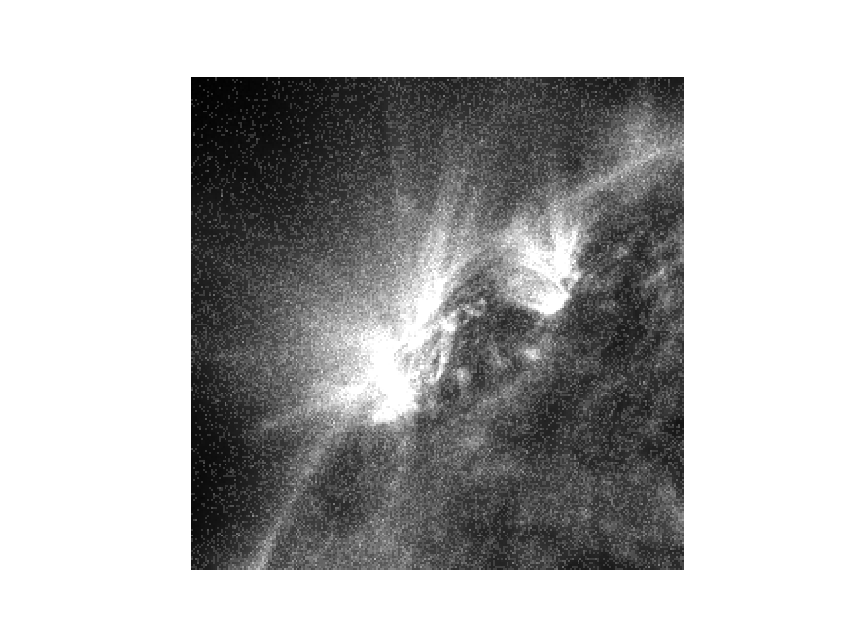

In [94]:
plt.figure()
plt.imshow(np.sqrt(data[800:1050,250:500,25]), origin='lower', interpolation='None', cmap='gray', vmax=3)
plt.axis("off")
plt.show()

# Define all image section coordinates

The image is broken into many small cubes for processing and cleaning. We define all those before hand (not really necessary if we just had a number scheme) for simplicity. 

In [10]:
# define grid
#xstart, xend, xstep  = 600, 800, 3
xstart, xend, xstep = xwidth*2, data.shape[0] - (xwidth*2), 4

#ystart, yend, ystep = 600, 800, 3
ystart, yend, ystep = ywidth*2, data.shape[1] - (ywidth*2), 4

#tstart, tend, tstep = 50, 56, 3
tstart, tend, tstep = twidth, data.shape[2] - twidth, 4

x_ = np.arange(xstart, xend, xstep)
y_ = np.arange(ystart, yend, ystep)
t_ = np.arange(tstart, tend, tstep)
coords = []
for t in t_:
    for y in y_:
        for x in x_:
            coords.append((x,y,t))

In [97]:
print("There are {} image sections".format(len(coords)))

There are 1612688 image sections


#  Define hanning window

Since this approach relies on fourier transforms, we want to avoid the edges of the image showing up signicantly in fourier space. We also must add up overlapping image sections. Thus, we multiply each image section by a hanning window thus consequently convolving the fourier space.

In [12]:
# equation for a hanning window
hanning_window_3D = lambda x, y, t : (np.power(np.sin((x + 0.5)*np.pi / xwidth), 2.0) * 
                                       np.power(np.sin((y + 0.5) * np.pi / ywidth), 2.0) * 
                                       np.power(np.sin((t + 0.5) * np.pi / twidth), 2.0))

# set up our hanning window array
hanning = np.zeros((xwidth, ywidth, twidth))
for x in range(hanning.shape[0]):
    for y in range(hanning.shape[1]):
        for t in range(hanning.shape[2]):
            hanning[x,y,t] = hanning_window_3D(x,y,t)

You can inspect the hanning window cube below. For visualization purposes, we have to choose one time entry to show. Here it is set at 0.

<IPython.core.display.Javascript object>


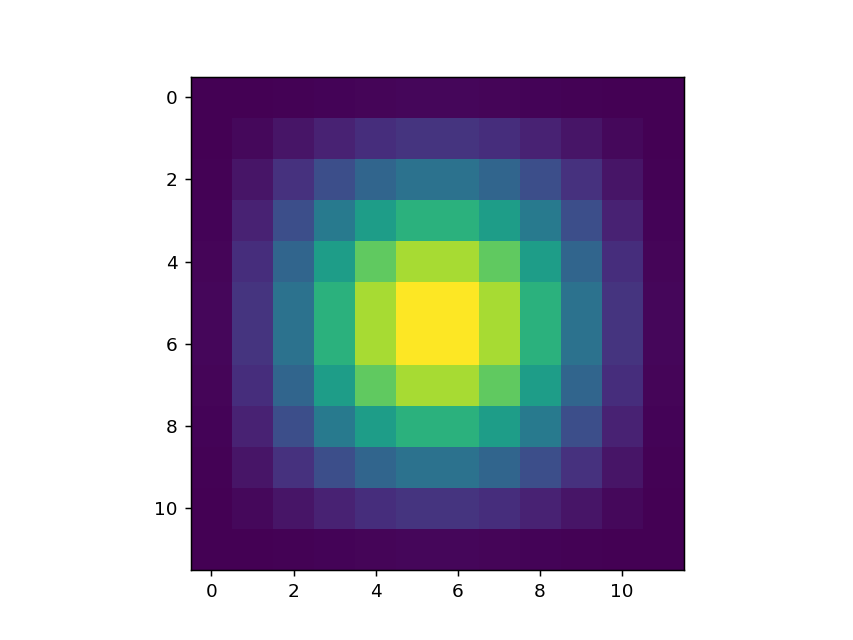

In [98]:
time = 0
plt.figure()
plt.imshow(hanning[:,:,time])
plt.show()

# Determine beta

The noise gating approach requires some estimation of what the noise looks like in fourier space. We'll call this the beta term (see the paper for a more rigorous definition). Since most of the fourier space is dominated by noise, we just take the median of some sizeable number of image region fourier transforms to be the noise model.

In [14]:
beta_stack = []
N = 10000

# for N random regions of the image cube we will take the fourier transform 
# and use it to estimate the noise model, beta
for i in np.random.choice(len(coords),N):
    x, y, t = coords[i]

    # get the data
    image_section = data[x-xwidth//2 : x+xwidth//2, 
                         y-ywidth//2 : y+ywidth//2, 
                         t-twidth//2 : t+twidth//2].copy()
    image_section *= hanning # multiply by hanning window
    
    # sum of the square root of the image section
    imbar = np.sum(np.sqrt(image_section))
    
    # take the fourier transform and get the magnitude
    beta_fourier = np.fft.fftshift(fft(image_section))
    beta_fourier_magnitude = np.abs(beta_fourier)
    
    # add this beta term to the stack
    beta_stack.append(beta_fourier_magnitude / imbar)

# from all the sections use the median
beta_approx = np.median(np.stack(beta_stack), axis=0)

Instead of using median, you can also use some other defined percentile as below. 

In [15]:
percentile = 50
beta_approx = np.percentile(np.stack(beta_stack), percentile, axis=0)

We can examine this beta variable below.

<IPython.core.display.Javascript object>


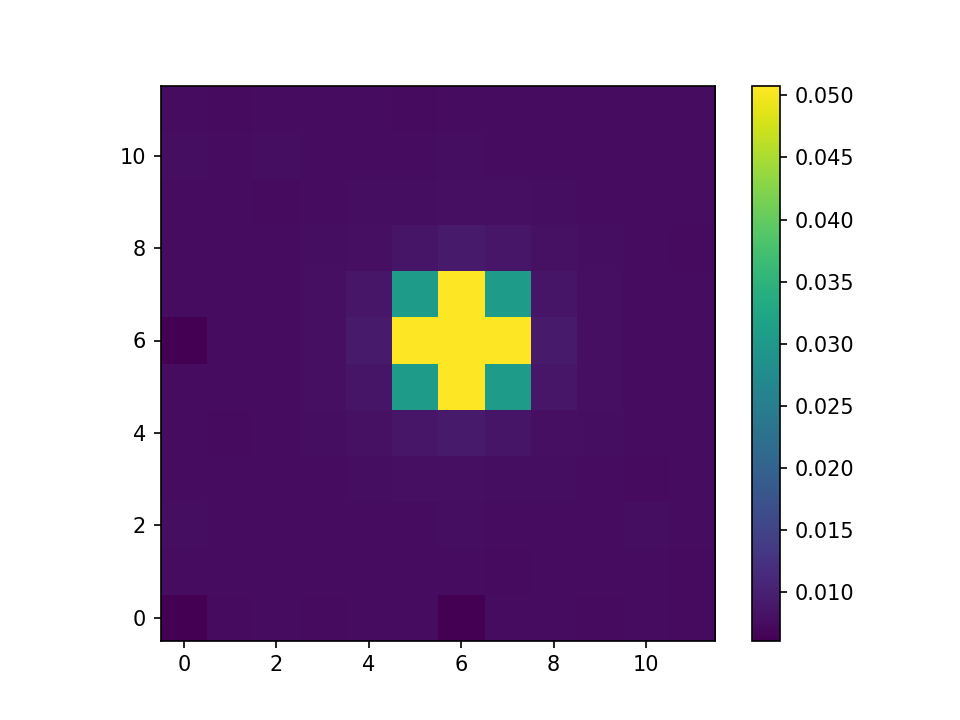

In [16]:
plt.figure()
plt.imshow(beta_approx[:,:,6], origin='lower', interpolation='None', 
          vmin=np.min(beta_approx), vmax=0.5*np.max(beta_approx))
plt.colorbar()
plt.show()

We no longer need this so we can delete it.

In [17]:
del beta_stack

# Do all the processing

In [19]:
gated_image = np.zeros_like(data)
times = []

# over all image sections
for i in range(len(coords)):
    start = time.time()
    x, y, t = coords[i]

    # get image section copy so as not to manipulate it
    image_section = data[x-xwidth//2 : x+xwidth//2, 
                         y-ywidth//2 : y+ywidth//2, 
                         t-twidth//2 : t+twidth//2].copy()

    # adjust by hanning window
    image_section *= hanning
    imbar = np.sum(np.sqrt(image_section))

    # determine fourier magnitude
    fourier = np.fft.fftshift(fft(image_section))
    fourier_magnitude = np.abs(fourier)
    
    # estimate noise and set the threshold to ignore
    noise = beta_approx * imbar
    threshold = noise * gamma
    
    # any magnitude outside this limit is noise
    gate_filter = np.logical_not(fourier_magnitude < threshold)
    # always preserve the center 3x3 components because they're signal
    gate_filter[5:8, 5:8, 5:8] = True
    final_fourier = fourier * gate_filter
    
    # we can use the wiener filter instead of the gate filter here
    #wiener_filter =  (fourier_magnitude / threshold) / (1 + (fourier_magnitude / threshold))
    #final_fourier = fourier * wiener_filter
    
    # adjust by hanning filter again
    final_image = hanning * np.abs(ifft(np.fft.ifftshift(final_fourier)))

    # add into the final gated image
    gated_image[x-xwidth//2 : x+xwidth//2,
                y-ywidth//2 : y+ywidth//2, 
                t-twidth//2 : t+twidth//2] += final_image
    
    times.append(time.time() - start)

<IPython.core.display.Javascript object>


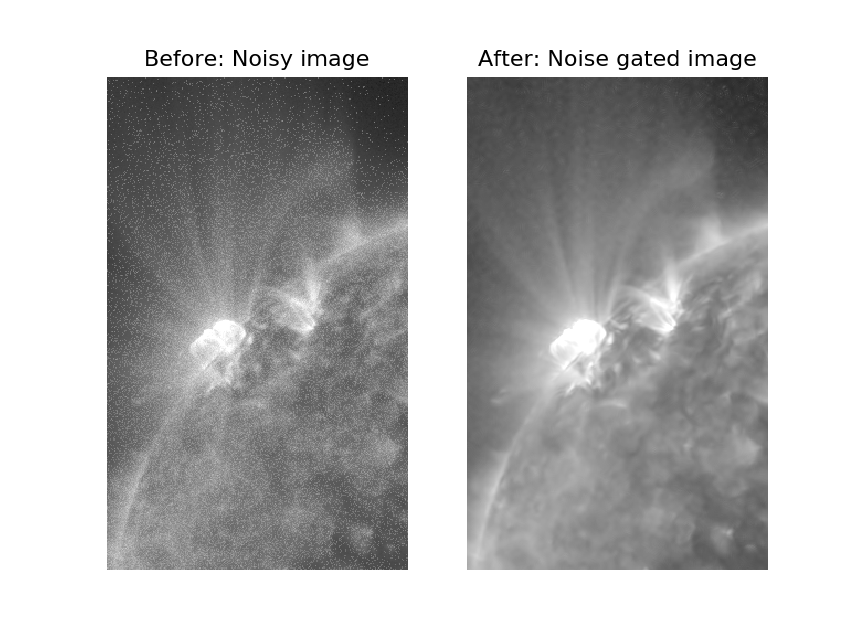

In [110]:
fig, axs= plt.subplots(1,2, sharex=True, sharey=True)
axs[0].imshow(np.power(data[:,:,50],0.25), origin='lower', interpolation='None', cmap='gray',vmax=2)
axs[0].set_axis_off()
axs[0].set_title("Before: Noisy image")

axs[1].imshow(np.power(gated_image[:,:,50],0.25), origin='lower', interpolation='None', cmap='gray', vmax=2)
axs[1].set_axis_off()
axs[1].set_title("After: Noise gated image")

fig.show()

# Make a movie!

Since this is done in a three-dimensional fashion, we want to see how much improvement there is in the three dimensional space. Thus, we make a movie! 

In [ ]:
# set the vixual parameters
xstart, xend, ystart, yend = 800, 1050, 250, 500 #part to zoom in on
vmin, vmax = 0, 3.7 # the range of values to show
power = 0.5 # the exponential scaling to show both dim and bright features

for i in range(data.shape[2]):
    print(i)
    out = scipy.ndimage.filters.gaussian_filter(data[:,:,i], 1.8)
    fig, axes = plt.subplots(2,2, sharex=True, sharey=True, dpi=400)

    with fits.open(fns[i]) as img:
        rawdata = img[0].data
    
    # raw data
    axes[0,0].imshow(np.power(rawdata[xstart:xend,ystart:yend], power), 
                     origin='lower', interpolation='None', cmap="gray",
                     vmin=vmin, vmax=vmax)
    axes[0,0].set_axis_off()
    axes[0,0].set_title("Original")

    # noisy data
    axes[0,1].imshow(np.power(data[:,:,i][xstart:xend,ystart:yend], power), 
                     origin='lower', interpolation='None', cmap="gray", 
                     vmin=vmin, vmax=vmax)
    axes[0,1].set_axis_off()
    axes[0,1].set_title("Noise added")

    # noise gated data
    axes[1,0].imshow(np.power(gated_image[:,:,i][xstart:xend,ystart:yend], power), 
                     origin='lower', interpolation='None', cmap="gray", 
                     vmin=vmin, vmax=vmax*1.5)
    axes[1,0].set_axis_off()
    axes[1,0].set_title("Noise gated")

    # clean data
    axes[1,1].imshow(np.power(out[xstart:xend,ystart:yend], power), 
                     origin='lower', interpolation='None', cmap="gray", 
                     vmin=vmin, vmax=vmax)
    axes[1,1].set_axis_off()
    axes[1,1].set_title("Gaussian filtered")


    #fig.show();0
    fig.savefig("/Users/mhughes/Desktop/movie/{:02d}.png".format(i))
    plt.close()

After this, I used ffmpeg to convert the images to a movie:

```cat *.png | ffmpeg -framerate 5 -f image2pipe -i - -pix_fmt yuv420p output.mp4 ```